1. ensure dependencies

In [1]:
import sys
import os
from pathlib import Path

current_dir=str(Path(os.getcwd()).parent.parent.parent)
print(f"Current dir: {current_dir}")
sys.path.insert(0, current_dir)

Current dir: d:\Programming\Python\comfyui-image-scorer


2. main train

In [2]:
from shared.paths import filtered_data
from shared.loaders.training_loader import training_loader
from shared.training.data_transformer import data_transformer
import numpy as np

retrain = False
if retrain:
    training_loader.remove_training_models()

print("--- Step 1: Loading Data ---")
if not os.path.exists(filtered_data):
    x = training_loader.load_vectors()
else:
    x = np.empty(0)
y = training_loader.load_scores()


print(f"Loaded Data Shape: {y.shape}")

print("\n--- Step 2: Filtering Unused Features ---")
# Removes features with zero variance or zero importance in a quick probe
x, kept_indices = data_transformer.filter_unused_features(x, y, 500)
print(f"Filtered Data Shape: {x.shape}")

# print("\n--- Step 3: Generating Interaction Features ---")
# Adds top 500 polynomial interactions (feature_A * feature_B)
#x, _ = data_transformer.add_interaction_features(x, y, target_k=1000)
# print(f"Final Data Shape (with Interactions): {x.shape}")
print("Data Preparation Complete.")

--- Step 1: Loading Data ---
Loaded Data Shape: (1000,)

--- Step 2: Filtering Unused Features ---
Filtered Data Shape: (1000, 2912)
Data Preparation Complete.


Training LightGBM:  32%|███▏      | 64/201 [00:01<00:03, 42.98it/s]

first backup metric ndcg@1
Saved model and diagnostics to: D:\Programming\Python\comfyui-image-scorer\output\models\model.npz
Training complete. Evaluation metrics:
  mae: 2.7450
  rmse: 3.0668
  model_type: LGBMRanker
  training_time: 1.4892
  n_iter: 1.0000
  ndcg: 0.2258
  loss_curve: [np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.22580645161290322), np.float64(0.2258

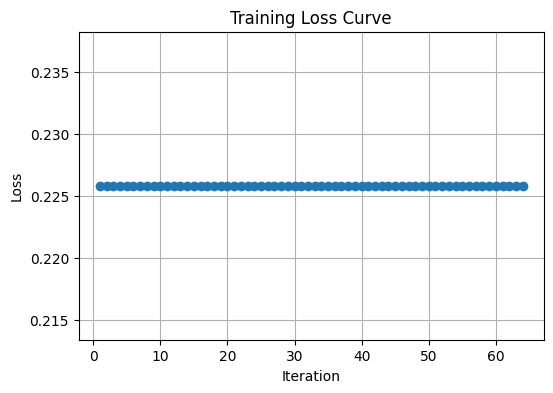

In [3]:
from typing import Dict, Any
from shared.config import config

from external_modules.step03training.full_data.analysis import plot_loss_curve

from shared.paths import training_model
from shared.training.model_trainer import model_trainer
from shared.loaders.training_loader import training_loader

training_cfg = config["training"]

config_selection = "top"

current_config = training_cfg[config_selection]

model, metrics = model_trainer.train_model(
    config_dict=current_config,
    X=x,
    y=y,
)

score = float(metrics["ndcg"])
training_time = float(metrics["training_time"])
new_config: Dict[str, Any] = {
    **current_config,
    "best_score": score,
    "training_time": training_time,
}
config["training"][config_selection].update(new_config)

training_loader.save_training_model(model, additional_data=metrics)

# Print metrics like run_training did
print("Training complete. Evaluation metrics:")
for k, v in metrics.items():
    try:
        print(f"  {k}: {v:.4f}")
    except Exception:
        print("  {}: {}".format(k, v))

# Friendly post-training suggestion when no diagnostics available
if not metrics.get("has_loss_curve") and not metrics.get("has_n_iter"):
    print(
        "Warning: No training iterations or loss curve were recorded. Consider increasing 'epochs' or using solver='adam' with verbose=True to collect diagnostics."
    )
else:
    plot_loss_curve(metrics)

In [4]:
import numpy as np
import json
from shared.loaders.training_loader import training_loader

data = training_loader.load_training_model()
# data = np.load(training_model, allow_pickle=True)
if not data:
    raise FileNotFoundError("training data not found")

print("Saved model diagnostics keys:", list(data.keys()))
if "params" in data:
    raw = data["params"]
    print(f"raw data type: {type(raw)}")
    if isinstance(raw, np.ndarray) and raw.shape == ():
        raw = raw.item()
    if isinstance(raw, bytes):
        raw = raw.decode("utf-8")
    if isinstance(raw, str):
        try:
            params = json.loads(raw)
        except Exception:
            try:
                params = eval(raw)
            except Exception:
                params = raw
    else:
        params = raw
    print("  saved params:", params)


metrics_blob = None
if "metrics" in data:
    metrics_blob = data["metrics"]
    try:
        if isinstance(metrics_blob, _np.ndarray) and metrics_blob.shape == ():
            metrics_blob = metrics_blob.item()
    except Exception:
        pass
if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "loss_curve" in metrics_blob
):
    lc = np.asarray(metrics_blob["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])
    else:
        print("  loss_curve present but empty")
elif "loss_curve" in data:
    lc = np.asarray(data["loss_curve"])
    if lc.size > 0:
        print("  loss_curve (first 10):", lc[:10])

if (
    metrics_blob is not None
    and isinstance(metrics_blob, dict)
    and "n_iter" in metrics_blob
):
    print("  saved n_iter:", int(metrics_blob["n_iter"]))
elif "n_iter" in data:
    print("  saved n_iter:", int(data["n_iter"]))

AttributeError: 'LGBMRanker' object has no attribute 'keys'

3. compare with real data

In [ ]:
from external_modules.step03training.full_data.analysis import compare_model_vs_data
compare_model_vs_data(training_model, x, y)